# __Customer Lifetime Value Estimation with BG-NBD and Gamma-Gamma__

## __Business Problem__

FLO company wants to determine roadmap for  sales and marketing activities. 
In order to make a medium-long-term plan company needs to estimate the potential value of the customers. 

## __Story of the Dataset__

The dataset consists of the information obtained from the past shopping behavior of customers who made their last purchases from Flo as OmniChannel (both online and offline shopper) between 2020 and 2021.

__master_id :__ Unique customer number

__order_channel :__ Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)

__last_order_channel :__ The channel where the most recent purchase was made

__first_order_date :__ Date of the customer's first purchase

__last_order_date :__ Customer's last purchase date

__last_order_date_online :__ The date of the last purchase made by the customer on the online platform

__last_order_date_offline :__ The date of the last purchase made by the customer on the offline platform

__order_num_total_ever_online :__ The total number of purchases made by the customer on the online platform

__order_num_total_ever_offline :__ Total number of purchases made by the customer offline

__customer_value_total_ever_offline :__ Total fee paid by the customer for offline purchases

__customer_value_total_ever_online :__ The total fee paid by the customer for their online shopping

__interested_in_categories_12 :__ List of categories the customer has shopped in the last 12 months

Importing necessary libraries

In [1]:
import datetime as dt
import pandas as pd
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import matplotlib.pyplot as plt

In [2]:
pd.options.display.width= None
pd.options.display.max_columns= None
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option("expand_frame_repr", False)

Importing the Data

In [11]:
df_=pd.read_csv("data_20k.csv")
df = df_.copy()
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR]


Descriptive Statistics

In [12]:
print(df.describe().T)
print(20*"#"+" Null Values "+20*"#")
print(df.isnull().sum())
print(20*"#"+" Data Types "+20*"#")
df.info()

                                      count    mean     std    min     25%     50%     75%       max
order_num_total_ever_online       19945.000   3.111   4.226  1.000   1.000   2.000   4.000   200.000
order_num_total_ever_offline      19945.000   1.914   2.063  1.000   1.000   1.000   2.000   109.000
customer_value_total_ever_offline 19945.000 253.923 301.533 10.000  99.990 179.980 319.970 18119.140
customer_value_total_ever_online  19945.000 497.322 832.602 12.990 149.980 286.460 578.440 45220.130
#################### Null Values ####################
master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_i

Function written to suppress outlier values,
I chose the outlier values 0.01 and 0.99 in order not to spoil the naturalness of the dataset too much.

In [13]:
def replace_with_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    dataframe.loc[(dataframe[variable] > up_limit.round()), variable] = up_limit.round() 

Boxplot of the float variables.

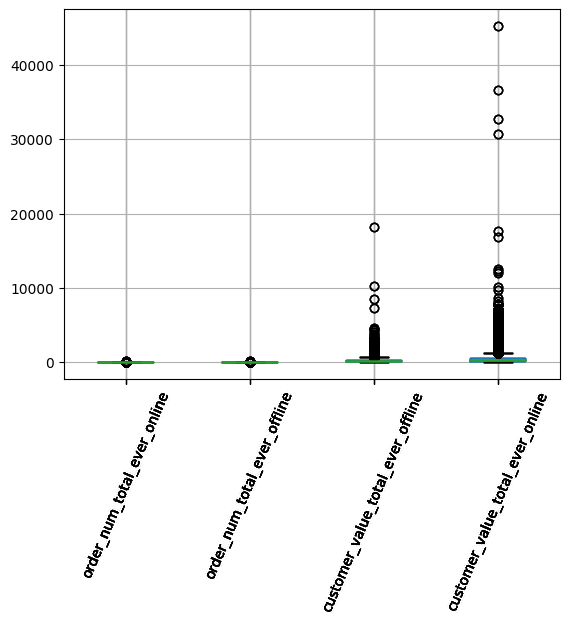

In [16]:
df.boxplot(column= ["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online"],
                    rot=67);
plt.show()

In [18]:
replace_with_thresholds(df,"order_num_total_ever_online")
replace_with_thresholds(df,"order_num_total_ever_offline")
replace_with_thresholds(df,"customer_value_total_ever_offline")
replace_with_thresholds(df,"customer_value_total_ever_online")

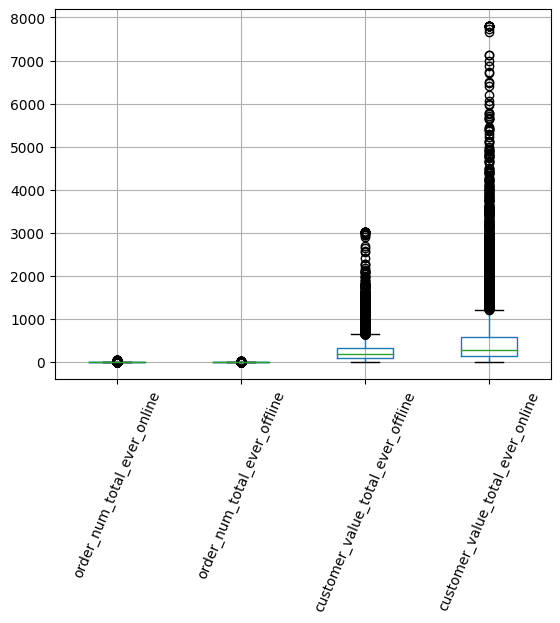

In [19]:
df.boxplot(column= ["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online"],
                    rot=67);
plt.show()

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,2.000,4.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,2.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,99.990,179.980,319.970,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,149.980,286.460,578.440,7800.000


Summing number of orders and payments.

In [21]:
df["total_order"]=df["order_num_total_ever_online"]+df.order_num_total_ever_offline
df["monetary"]=df.customer_value_total_ever_offline+df.customer_value_total_ever_online


In [22]:
df.loc[:, df.columns.str.contains("date")]=df.loc[:, df.columns.str.contains("date")]\
                                             .apply(pd.to_datetime,format='%Y-%m-%d')
df.last_order_date.max()
#Timestamp('2021-05-30 00:00:00')
#The date of the analysis was selected 2 days after the last_order_date.
today_date=dt.datetime(2021,6,2)
df["T"]=(today_date-df.first_order_date).dt.days#customer's age
df["recency"]=(df.last_order_date-df.first_order_date).dt.days#period the customer is active

In [23]:
cltv=df[["master_id","recency","T","total_order","monetary"]]
cltv.columns=["customer_id","recency","T","frequency","monetary"]
cltv["recency_cltv_weekly"]=cltv.recency/7
cltv["T_weekly"]=cltv["T"] / 7
cltv["monetary_cltv_avg"]=cltv.monetary/cltv.frequency
cltv.drop(columns=["recency","T"],inplace=True)
cltv.head()

,customer_id,frequency,monetary,recency_cltv_weekly,T_weekly,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,5.000,939.370,17.000,30.714,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,21.000,2013.550,209.857,225.000,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,5.000,585.320,52.286,79.000,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,2.000,121.970,1.571,21.000,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2.000,209.980,83.143,95.571,104.990


Fit the model

In [24]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv['frequency'],
        cltv['recency_cltv_weekly'],
        cltv['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.40, b: 0.00, r: 3.67>

Expected purchase amount from the customer in the 3 and 6 month periods

In [25]:
cltv["exp_sales_3_month"]=bgf.conditional_expected_number_of_purchases_up_to_time(4*3,
                                                        cltv['frequency'],
                                                        cltv['recency_cltv_weekly'],
                                                        cltv['T_weekly'])
                                                        

In [26]:
cltv["exp_sales_6_month"]=bgf.conditional_expected_number_of_purchases_up_to_time(4*6,
                                                        cltv['frequency'],
                                                        cltv['recency_cltv_weekly'],
                                                        cltv['T_weekly'])
cltv.head()

,customer_id,frequency,monetary,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,5.000,939.370,17.000,30.714,187.874,0.971,1.942
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,21.000,2013.550,209.857,225.000,95.883,0.982,1.964
2,69b69676-1a40-11ea-941b-000d3a38a36f,5.000,585.320,52.286,79.000,117.064,0.669,1.339
3,1854e56c-491f-11eb-806e-000d3a38a36f,2.000,121.970,1.571,21.000,60.985,0.698,1.397
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2.000,209.980,83.143,95.571,104.990,0.396,0.791


Inspecting customers according to expected sales for 6 months.
    When the first 5 customers are examined, it can be understood from the 2nd and 4th customers, for example, that the number of products purchased is not the only factor. At this point, the model also takes into account the age of the customers and the shopping periods they are active in, namely T and Recency values. For example, it is predicted by the model that the purchasing potential of the customers whose recency and T values are close to each other increase.


In [27]:
cltv.sort_values(by = "exp_sales_6_month", ascending =False).head()

,customer_id,frequency,monetary,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,52.000,8643.680,62.714,67.429,166.225,4.645,9.289
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,29.000,4793.630,39.714,40.143,165.298,3.364,6.728
8328,1902bf80-0035-11eb-8341-000d3a38a36f,25.000,2435.990,28.857,33.429,97.440,3.132,6.265
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,31.000,7084.430,52.571,58.857,228.530,3.076,6.152
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,27.000,3816.580,38.000,46.571,141.355,2.993,5.986


Constructing Gamma-Gamma Model

In [28]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv['frequency'], cltv['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

Calculation of Lifetime average monetary and monetary for the 6 months period

In [32]:
cltv["exp_average_value"]=ggf.conditional_expected_average_profit(cltv['frequency'], cltv['monetary_cltv_avg'])
cltv["cltv_for_6_months"] = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency_cltv_weekly'],
                                   cltv['T_weekly'],
                                   cltv['monetary'],
                                   time=6,  # 6 months
                                   freq="W",
                                   discount_rate=0.01)
cltv.sort_values(by = "cltv_for_6_months", ascending =False).head()

,customer_id,frequency,monetary,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv_for_6_months
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,52.000,8643.680,62.714,67.429,166.225,4.645,9.289,166.712,84454.403
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,49.000,7930.490,133.143,147.286,161.847,2.826,5.651,162.353,47144.668
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,31.000,7084.430,52.571,58.857,228.530,3.076,6.152,229.607,45916.136
14181,0e8c7b30-ac18-11e9-a2fc-000d3a38a36f,48.000,8181.190,141.714,159.857,170.441,2.624,5.249,170.981,45175.215
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,43.000,6755.840,103.143,112.000,157.113,2.973,5.945,157.675,42267.154


Segmentation of the Customers according to predicted 6 months lifetime values.
In fact, segmentation is a very important approach for companies because it can help a lot in developing a marketing strategy by bringing together customers with similar profiles.  

In [ ]:
cltv["segment"]=pd.qcut(cltv.cltv_for_6_months,4,labels=["D","C","B","A"])
cltv.groupby("segment").agg({"mean"})


,frequency,monetary,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv_for_6_months
,mean,mean,mean,mean,mean,mean,mean,mean,mean
segment,,,,,,,,,
D,2.570,260.259,103.409,126.887,104.819,0.408,0.816,112.765,225.932
C,3.379,450.912,84.316,104.892,146.414,0.499,0.999,155.028,470.527
B,4.683,703.270,88.115,106.607,168.859,0.579,1.158,176.206,849.759
A,9.281,1552.165,105.212,120.071,188.314,0.818,1.636,192.964,2973.308
